In [1]:
import sys
import ee, geemap
import ipywidgets as widgets
import habitat_pl.viz.corine as corine
import importlib
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

ee.Authenticate()
ee.Initialize(project='agh-ml-2025')
importlib.reload(corine)

# to keep things consistent
YEAR = 2021
MAX_PER_CLASS = 200
TSNE_PERPLEXITY = 30
UMAP_N_NEIGHBORS = 30
UMAP_MIN_DIST = 0.1
SCALE = 100
SAMPLES_PER_CLASS_RAW = 400
MAX_PER_CLASS_FINAL = 200
MAX_PER_CLASS_TILE = 200
RANDOM_SEED = 123
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

d:\studia\Y5S1\ML_for_Space_Tech_2\.venv\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.5) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [2]:
import ipywidgets as widgets
import habitat_pl.viz.corine as corine
import importlib

importlib.reload(corine)
region = (
    ee.FeatureCollection('FAO/GAUL/2015/level2')
    .filter(ee.Filter.eq('ADM2_NAME', 'Krakow'))
    .geometry()
)
emb = (
    ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
    .filterDate('2021-01-01', '2022-01-01')
    .filterBounds(region)
    .mosaic()
    .clip(region)
)
m = geemap.Map()
m.centerObject(region, 10)
m.add_basemap('Esri.WorldImagery')
m.addLayer(
    emb,
    {'min': -0.3, 'max': 0.3, 'bands': ['A01', 'A16', 'A09']},
    'Embeddings 2021'
)

clc = (
    ee.Image('COPERNICUS/CORINE/V20/100m/2018')
    .select('landcover')
    .clip(region)
)
clc_idx = (
    clc
    .remap(corine.codes, list(range(1, len(corine.codes) + 1)))
    .rename('landcover_idx')
)
m.addLayer(clc_idx, corine.vis, 'CORINE 2018')
legend = m.add_legend(
    title="CORINE Land Cover 2018",
    legend_dict=corine.legend_dict
)
m


Map(center=[50.055221250128405, 19.99875758870854], controls=(WidgetControl(options=['position', 'transparent_…

In [3]:
AOI = region

In [4]:
# GSE
emb_img = (
    ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
    .filterDate(f'{YEAR}-01-01', f'{YEAR+1}-01-01')
    .filterBounds(AOI)
    .mosaic()
    .clip(AOI)
)
emb_bands = [f"A{i:02d}" for i in range(64)]
emb_img = emb_img.select(emb_bands)

In [5]:
clc_raw = ee.Image('COPERNICUS/CORINE/V20/100m/2018').select('landcover').clip(AOI)
clc_idx = clc_raw.rename('landcover_idx')
mask = clc_idx.gt(0)
emb_masked = emb_img.updateMask(mask)
stack = emb_masked.addBands(clc_idx)
classes_img = clc_idx.updateMask(mask)
present_idx = (
    classes_img
    .reduceRegion(
        reducer=ee.Reducer.frequencyHistogram(),
        geometry=AOI,
        scale=SCALE,
        maxPixels=1e9
    )
    .get('landcover_idx')
)
present_idx = ee.Dictionary(present_idx).keys().map(lambda x: ee.Number.parse(x))
present_idx = present_idx.getInfo()
present_idx = sorted(set(int(v) for v in present_idx))
present_idx

[111,
 112,
 121,
 122,
 132,
 141,
 142,
 211,
 231,
 242,
 243,
 311,
 312,
 313,
 324,
 511,
 512]

In [6]:
# Use a single stratified sampling to avoid many concurrent aggregations
# Add lon/lat bands so we don't need to fetch geometries client-side
stack_with_coords = stack.addBands(ee.Image.pixelLonLat())

samples_fc = stack_with_coords.stratifiedSample(
    numPoints=SAMPLES_PER_CLASS_RAW,
    classBand="landcover_idx",
    region=AOI,
    scale=SCALE,
    seed=RANDOM_SEED,
    geometries=False,  # reduce payload
    classValues=present_idx,
    classPoints=[SAMPLES_PER_CLASS_RAW] * len(present_idx),
)

# Fetch results in chunks to avoid the 5000-element client limit
size = samples_fc.size().getInfo()
batch_size = 5000
rows = []
for offset in range(0, size, batch_size):
    subset = samples_fc.toList(batch_size, offset)
    dicts = ee.List(subset).map(lambda f: ee.Feature(f).toDictionary()).getInfo()
    rows.extend(dicts)

df = pd.DataFrame(rows)
df = df.dropna().reset_index(drop=True)
print("Columns in df:", df.columns.tolist())
print(df.head())

Columns in df: ['A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63', 'landcover_idx', 'latitude', 'longitude']
        A00       A01       A02       A03       A04       A05       A06  \
0 -0.004983 -0.267958  0.051734 -0.141730  0.093564 -0.251965 -0.051734   
1 -0.012057 -0.259900  0.066990 -0.186082  0.113741 -0.206936 -0.041584   
2  0.029773 -0.336855 -0.029773 -0.192910  0.103406 -0.113741  0.044844   
3 -0.027128 -0.267958  0.135886 -0.199862  0.059116 -0.214133 -0.024606   
4 -0.041584 -0.310096  0.059116 -0.166336  0.088827 -0.236463 -0.084214   

        A07       A08       A09  ...       

In [7]:
import h3
cols = df.columns.tolist()
print("Columns v2 in df:", cols)
lat_col, lon_col = "latitude", "longitude"
if hasattr(h3, "geo_to_h3"):
    def cell_fn(lat, lon, res):
        return h3.geo_to_h3(lat, lon, res)
    def parent_fn(h, res):
        return h3.h3_to_parent(h, res)
else:
    def cell_fn(lat, lon, res):
        return h3.latlng_to_cell(lat, lon, res)
    def parent_fn(h, res):
        return h3.cell_to_parent(h, res)
def latlon_to_h3(row, res):
    return cell_fn(row[lat_col], row[lon_col], res)
df["h3_z6"] = df.apply(lambda r: latlon_to_h3(r, 6), axis=1)
df["h3_z4"] = df["h3_z6"].apply(lambda h: parent_fn(h, 4))
print(df[["landcover_idx", "latitude", "longitude", "h3_z4", "h3_z6"]].head())
print("NO classes:", df["landcover_idx"].nunique())
print("Classes H3 z4:", df["h3_z4"].nunique())

def balance_per_tile(df_in, label_col="landcover_idx", tile_col="h3_z4",
                     max_per_class_tile=200, seed=42):
    parts = []
    for (tile, cls), sub in df_in.groupby([tile_col, label_col]):
        if len(sub) > max_per_class_tile:
            parts.append(sub.sample(max_per_class_tile, random_state=seed))
        else:
            parts.append(sub)
    out = pd.concat(parts, axis=0)
    out = out.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    return out
df_bal = balance_per_tile(df)
print("Shape after balancing:", df_bal.shape)
print("Classes:", sorted(df_bal["landcover_idx"].unique()))

Columns v2 in df: ['A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63', 'landcover_idx', 'latitude', 'longitude']
   landcover_idx   latitude  longitude            h3_z4            h3_z6
0            111  50.067153  19.929574  841e2e7ffffffff  861e2e6b7ffffff
1            111  50.047390  19.944845  841e2e7ffffffff  861e2e6b7ffffff
2            111  50.060865  19.937659  841e2e7ffffffff  861e2e6b7ffffff
3            111  50.050984  19.949337  841e2e7ffffffff  861e2e6b7ffffff
4            111  50.068052  19.937659  841e2e7ffffffff  861e2e6b7ffffff
NO classes: 17
Classes H3 z4: 2
Shape after balancing

In [8]:
import numpy as np
import umap
emb_cols = [f"A{i:02d}" for i in range(64)]
X = df_bal[emb_cols].values.astype("float32")
y = df_bal["landcover_idx"].values.astype(int)
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique classes:", np.unique(y))
reducer = umap.UMAP(
    n_neighbors=UMAP_N_NEIGHBORS,
    min_dist=UMAP_MIN_DIST,
    n_components=2,
    metric="euclidean",
    random_state=RANDOM_SEED,
)
X_umap = reducer.fit_transform(X)
df_umap = df_bal.copy()
df_umap["umap1"] = X_umap[:, 0]
df_umap["umap2"] = X_umap[:, 1]
df_umap.head()

X shape: (4095, 64)
y shape: (4095,)
Unique classes: [111 112 121 122 132 141 142 211 231 242 243 311 312 313 324 511 512]


,A00,A01,A02,A03,A04,A05,A06,A07,A08,A09,...,A61,A62,A63,landcover_idx,latitude,longitude,h3_z6,h3_z4,umap1,umap2
0,-0.003937,-0.301423,-0.032541,-0.113741,0.141730,-0.108512,0.013841,-0.066990,-0.084214,-0.044844,...,0.038447,-0.079723,0.062991,112,50.020441,20.020304,861e2e687ffffff,841e2e7ffffffff,8.147855,9.274843
1,-0.124567,-0.160000,-0.079723,-0.267958,0.093564,-0.088827,0.035433,0.032541,-0.010396,-0.055363,...,-0.166336,-0.075356,-0.006151,231,50.029424,20.068813,861e2e68fffffff,841e2e7ffffffff,5.015217,4.041169
2,-0.113741,-0.113741,-0.084214,-0.079723,0.017778,-0.310096,0.022207,0.292872,0.075356,0.029773,...,-0.124567,0.010396,0.071111,324,50.082425,20.130796,861e2e6f7ffffff,841e2e7ffffffff,9.865291,3.252256
3,-0.124567,-0.038447,-0.130165,-0.019931,0.071111,-0.318893,0.032541,0.236463,0.141730,0.032541,...,-0.119093,-0.084214,0.079723,313,50.052780,19.877471,861e2e6b7ffffff,841e2e7ffffffff,8.688306,2.352647
4,-0.153787,-0.214133,0.010396,-0.244152,0.147697,-0.017778,0.035433,-0.059116,-0.024606,-0.141730,...,-0.071111,0.017778,-0.062991,242,50.058170,20.161339,861e2e6f7ffffff,841e2e7ffffffff,4.109934,5.517960


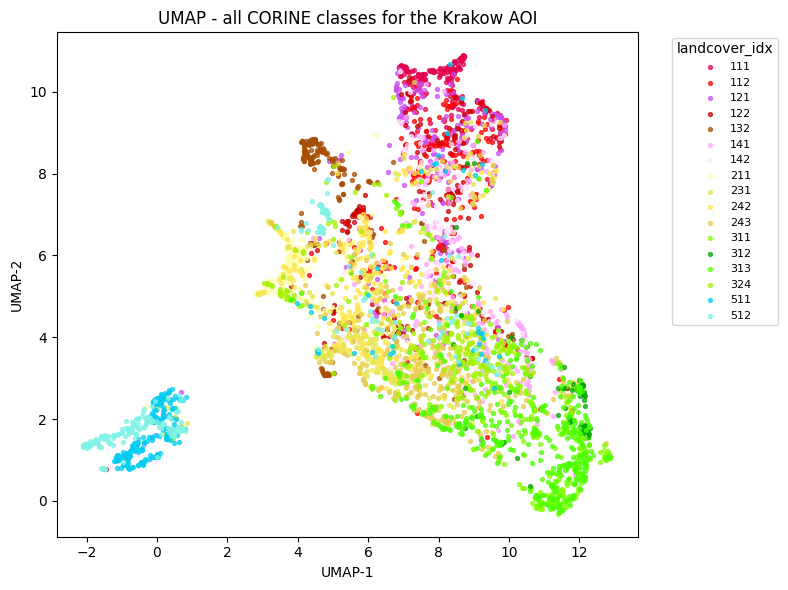

In [9]:
# Use official CORINE colors from the corine module
classes = np.sort(df_umap["landcover_idx"].unique())
CLC = [
    (111, "#e6004d", "Continuous urban fabric"),
    (112, "#ff0000", "Discontinuous urban fabric"),
    (121, "#cc4df2", "Industrial or commercial units"),
    (122, "#cc0000", "Road and rail networks and associated land"),
    (123, "#e6cccc", "Port areas"),
    (124, "#e6cce6", "Airports"),
    (131, "#a600cc", "Mineral extraction sites"),
    (132, "#a64d00", "Dump sites"),
    (133, "#ff4dff", "Construction sites"),
    (141, "#ffa6ff", "Green urban areas"),
    (142, "#ffe6ff", "Sport and leisure facilities"),
    (211, "#ffffa8", "Non-irrigated arable land"),
    (212, "#ffff00", "Permanently irrigated land"),
    (213, "#e6e600", "Rice fields"),
    (221, "#e68000", "Vineyards"),
    (222, "#f2a64d", "Fruit trees and berry plantations"),
    (223, "#e6a600", "Olive groves"),
    (231, "#e6e64d", "Pastures"),
    (241, "#ffe6a6", "Annual crops associated with permanent crops"),
    (242, "#ffe64d", "Complex cultivation patterns"),
    (243, "#e6cc4d", "Land principally occupied by agriculture with significant areas of natural vegetation"),
    (244, "#f2cca6", "Agro-forestry areas"),
    (311, "#80ff00", "Broad-leaved forest"),
    (312, "#00a600", "Coniferous forest"),
    (313, "#4dff00", "Mixed forest"),
    (321, "#ccf24d", "Natural grasslands"),
    (322, "#a6ff80", "Moors and heathland"),
    (323, "#a6e64d", "Sclerophyllous vegetation"),
    (324, "#a6f200", "Transitional woodland-shrub"),
    (331, "#e6e6e6", "Beaches - dunes - sands"),
    (332, "#cccccc", "Bare rocks"),
    (333, "#ccffcc", "Sparsely vegetated areas"),
    (334, "#000000", "Burnt areas"),
    (335, "#a6e6cc", "Glaciers and perpetual snow"),
    (411, "#a6a6ff", "Inland marshes"),
    (412, "#4d4dff", "Peat bogs"),
    (421, "#ccccff", "Salt marshes"),
    (422, "#e6e6ff", "Salines"),
    (423, "#a6a6e6", "Intertidal flats"),
    (511, "#00ccf2", "Water courses"),
    (512, "#80f2e6", "Water bodies"),
    (521, "#00ffa6", "Coastal lagoons"),
    (522, "#a6ffe6", "Estuaries"),
    (523, "#e6f2ff", "Sea and ocean"),
]

plt.figure(figsize=(8, 6))
for cls in classes:
    m = df_umap["landcover_idx"] == cls
    color = dict((code, color) for code, color, _ in CLC).get(int(cls), "#888888")
    plt.scatter(
        df_umap.loc[m, "umap1"],
        df_umap.loc[m, "umap2"],
        s=8,
        alpha=0.7,
        label=str(int(cls)),
        c=[color],
    )
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("UMAP - all CORINE classes for the Krakow AOI")
plt.legend(title="landcover_idx", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()


Available classes for the AOI: [111 112 121 122 132 141 142 211 231 242 243 311 312 313 324 511 512]


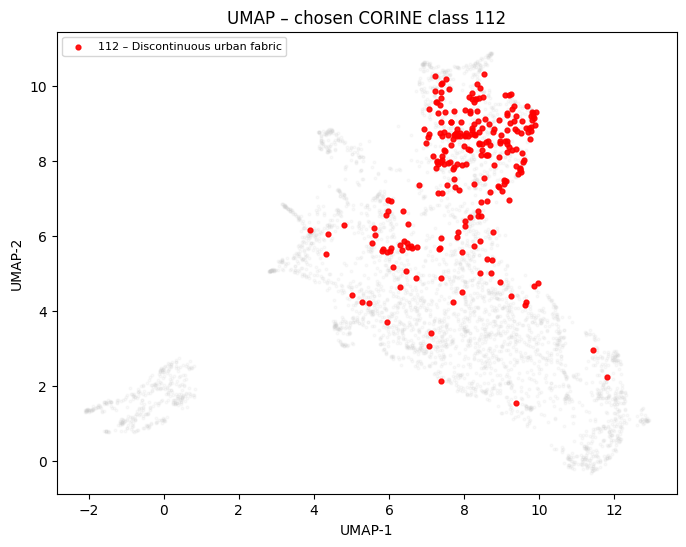

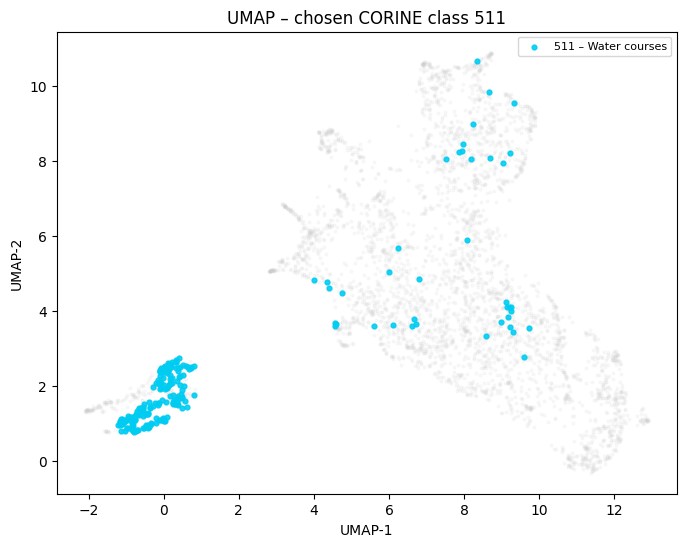

In [10]:
# Use CORINE colors from the previous cell (CLC)
color_map = {code: color for code, color, _ in CLC}
desc_map = {code: desc for code, _, desc in CLC}

print("Available classes for the AOI:", classes)
focus_classes = [112, 511]
for cls in focus_classes:
    m_focus = df_umap["landcover_idx"] == cls
    plt.figure(figsize=(8, 6))
    # background
    plt.scatter(
        df_umap.loc[~m_focus, "umap1"],
        df_umap.loc[~m_focus, "umap2"],
        s=4,
        alpha=0.1,
        c="#cccccc",
    )
    # focused class with CORINE color
    plt.scatter(
        df_umap.loc[m_focus, "umap1"],
        df_umap.loc[m_focus, "umap2"],
        s=12,
        alpha=0.9,
        c=[color_map.get(int(cls), "#888888")],
        label=f"{cls} – {desc_map.get(int(cls), 'unknown')}",
    )
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.title(f"UMAP – chosen CORINE class {cls}")
    plt.legend(loc="best", fontsize=8)
    plt.show()

In [11]:
import numpy as np
import pandas as pd
LABEL = "landcover_idx"
EMB_COLS = [f"A{i:02d}" for i in range(64)]
if "df_distilled" not in globals():
    base_df = df_umap.copy() if "df_umap" in globals() else df_bal.copy()
    if "is_outlier_svm" in base_df.columns:
        base_df = base_df.loc[~base_df["is_outlier_svm"]].copy()
    df_distilled = (
        base_df.groupby(LABEL, group_keys=False)
        .apply(lambda x: x.sample(n=min(len(x), 200), random_state=RANDOM_SEED))
        .reset_index(drop=True)
    )

print("df_distilled shape:", df_distilled.shape)
print("classes:", sorted(df_distilled[LABEL].unique())[:10], "...")
print("counts head:\n", df_distilled[LABEL].value_counts().head(10))


df_distilled shape: (3275, 71)
classes: [np.int64(111), np.int64(112), np.int64(121), np.int64(122), np.int64(132), np.int64(141), np.int64(142), np.int64(211), np.int64(231), np.int64(242)] ...
counts head:
 landcover_idx
111    200
112    200
121    200
122    200
132    200
141    200
142    200
211    200
231    200
242    200
Name: count, dtype: int64


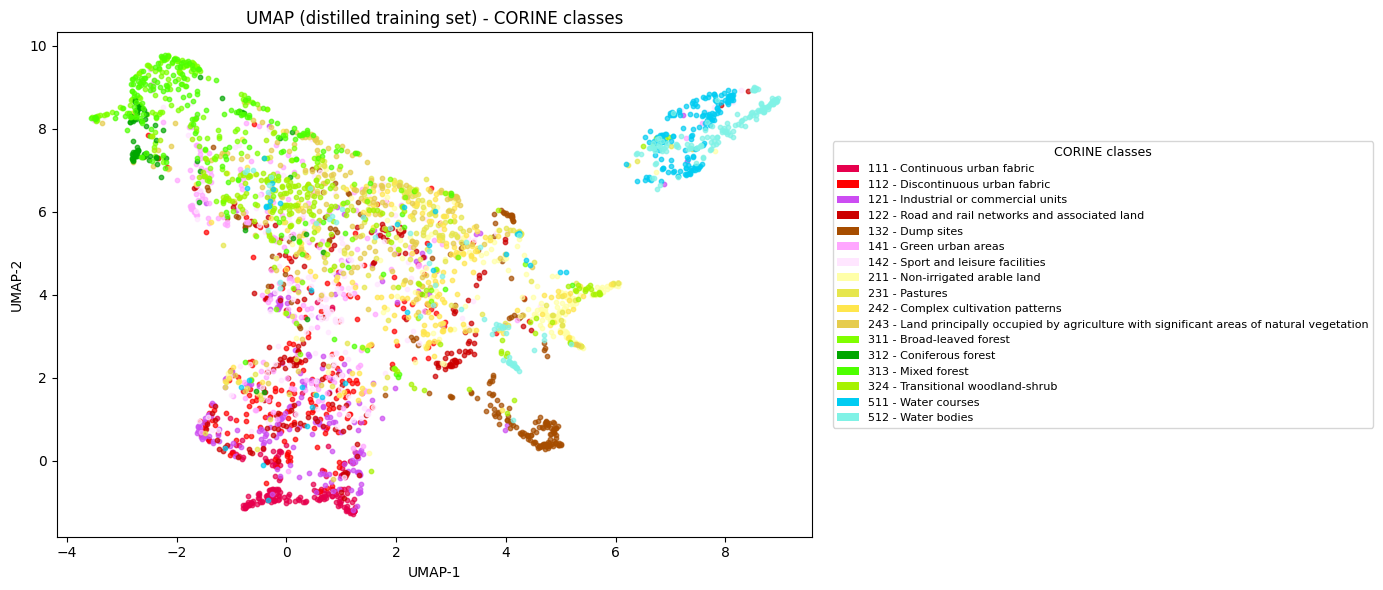

In [12]:
import umap
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
LABEL = "landcover_idx"
EMB_COLS = [f"A{i:02d}" for i in range(64)]
CLC = [
    (111, "#e6004d", "Continuous urban fabric"),
    (112, "#ff0000", "Discontinuous urban fabric"),
    (121, "#cc4df2", "Industrial or commercial units"),
    (122, "#cc0000", "Road and rail networks and associated land"),
    (123, "#e6cccc", "Port areas"),
    (124, "#e6cce6", "Airports"),
    (131, "#a600cc", "Mineral extraction sites"),
    (132, "#a64d00", "Dump sites"),
    (133, "#ff4dff", "Construction sites"),
    (141, "#ffa6ff", "Green urban areas"),
    (142, "#ffe6ff", "Sport and leisure facilities"),
    (211, "#ffffa8", "Non-irrigated arable land"),
    (212, "#ffff00", "Permanently irrigated land"),
    (213, "#e6e600", "Rice fields"),
    (221, "#e68000", "Vineyards"),
    (222, "#f2a64d", "Fruit trees and berry plantations"),
    (223, "#e6a600", "Olive groves"),
    (231, "#e6e64d", "Pastures"),
    (241, "#ffe6a6", "Annual crops associated with permanent crops"),
    (242, "#ffe64d", "Complex cultivation patterns"),
    (243, "#e6cc4d", "Land principally occupied by agriculture with significant areas of natural vegetation"),
    (244, "#f2cca6", "Agro-forestry areas"),
    (311, "#80ff00", "Broad-leaved forest"),
    (312, "#00a600", "Coniferous forest"),
    (313, "#4dff00", "Mixed forest"),
    (321, "#ccf24d", "Natural grasslands"),
    (322, "#a6ff80", "Moors and heathland"),
    (323, "#a6e64d", "Sclerophyllous vegetation"),
    (324, "#a6f200", "Transitional woodland-shrub"),
    (331, "#e6e6e6", "Beaches - dunes - sands"),
    (332, "#cccccc", "Bare rocks"),
    (333, "#ccffcc", "Sparsely vegetated areas"),
    (334, "#000000", "Burnt areas"),
    (335, "#a6e6cc", "Glaciers and perpetual snow"),
    (411, "#a6a6ff", "Inland marshes"),
    (412, "#4d4dff", "Peat bogs"),
    (421, "#ccccff", "Salt marshes"),
    (422, "#e6e6ff", "Salines"),
    (423, "#a6a6e6", "Intertidal flats"),
    (511, "#00ccf2", "Water courses"),
    (512, "#80f2e6", "Water bodies"),
    (521, "#00ffa6", "Coastal lagoons"),
    (522, "#a6ffe6", "Estuaries"),
    (523, "#e6f2ff", "Sea and ocean"),
]
CLC_COLOR = {code: col for code, col, _ in CLC}
CLC_NAME  = {code: name for code, _, name in CLC}
X = df_distilled[EMB_COLS].values.astype("float32")
y = df_distilled[LABEL].values.astype(int)
reducer = umap.UMAP(
    n_neighbors=globals().get("UMAP_N_NEIGHBORS", 30),
    min_dist=globals().get("UMAP_MIN_DIST", 0.1),
    n_components=2,
    metric="euclidean",
    random_state=globals().get("SEED", 123),
)
Z = reducer.fit_transform(X)
df_umap_distilled = df_distilled.copy()
df_umap_distilled["umap1"] = Z[:, 0]
df_umap_distilled["umap2"] = Z[:, 1]
classes = np.sort(df_umap_distilled[LABEL].unique())
plt.figure(figsize=(14, 6))
for cls in classes:
    m = df_umap_distilled[LABEL] == cls
    color = CLC_COLOR.get(int(cls), "#777777")
    plt.scatter(
        df_umap_distilled.loc[m, "umap1"],
        df_umap_distilled.loc[m, "umap2"],
        s=10,
        alpha=0.70,
        c=color,
    )
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("UMAP (distilled training set) - CORINE classes")
legend_handles = []
for cls in classes:
    code = int(cls)
    color = CLC_COLOR.get(code, "#777777")
    name = CLC_NAME.get(code, "Unknown")
    legend_handles.append(Patch(facecolor=color, edgecolor="none", label=f"{code} - {name}"))
plt.legend(
    handles=legend_handles,
    title="CORINE classes",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=True,
    fontsize=8,
    title_fontsize=9,
    ncol=1,
)

plt.tight_layout()
plt.show()

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
LABEL = "landcover_idx"
EMB_COLS = [f"A{i:02d}" for i in range(64)]  # A00..A63
SEED = 123
X = df_distilled[EMB_COLS].values.astype("float32")
y = df_distilled[LABEL].values.astype(int)
classes = np.sort(np.unique(y))
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.30,
    random_state=SEED,
    stratify=y
)
print("Train:", X_train.shape, "Val:", X_val.shape)
print("Classes:", classes.tolist())

Train: (2292, 64) Val: (983, 64)
Classes: [111, 112, 121, 122, 132, 141, 142, 211, 231, 242, 243, 311, 312, 313, 324, 511, 512]


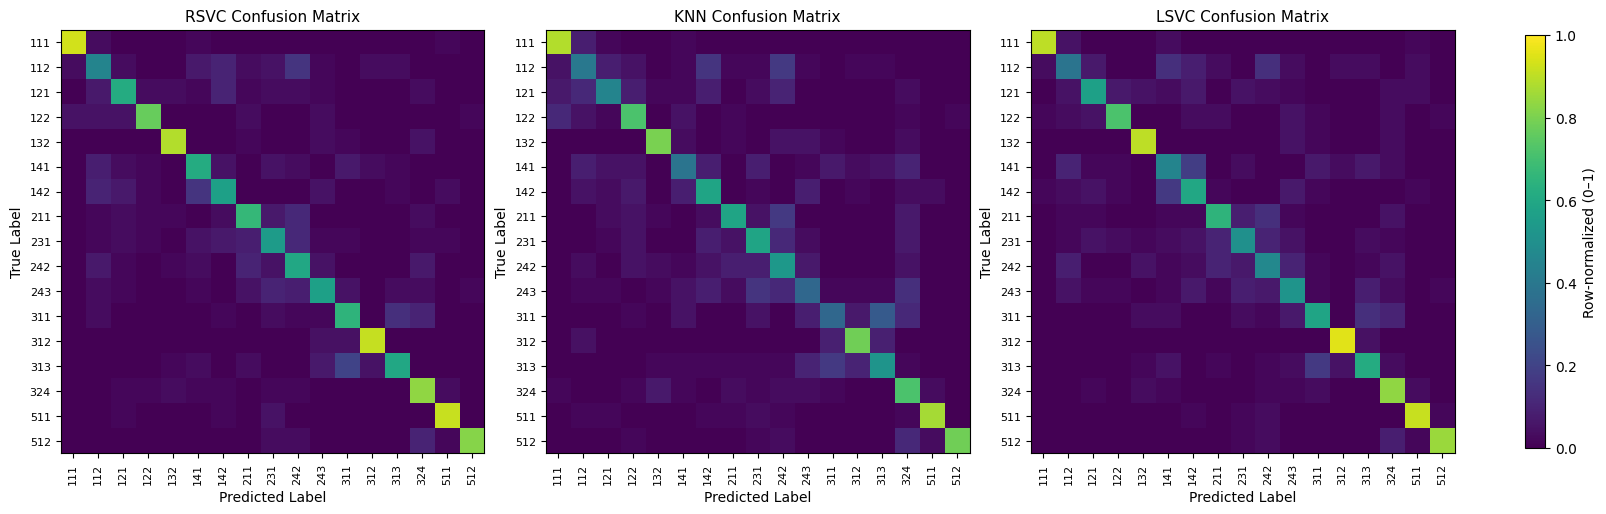

RSVC | acc=0.695 | balanced_acc=0.703 | f1_macro=0.700
KNN  | acc=0.596 | balanced_acc=0.603 | f1_macro=0.595
LSVC | acc=0.660 | balanced_acc=0.671 | f1_macro=0.665


In [14]:
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score, accuracy_score
def row_normalize(cm: np.ndarray) -> np.ndarray:
    cm = cm.astype("float64")
    row_sum = cm.sum(axis=1, keepdims=True)
    row_sum[row_sum == 0] = 1.0
    return cm / row_sum
def plot_cm(ax, cm_norm, title, labels):
    im = ax.imshow(cm_norm, vmin=0, vmax=1)
    ax.set_title(title, fontsize=11)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=90, fontsize=8)
    ax.set_yticklabels(labels, fontsize=8)
    return im
models = {
    "RSVC": make_pipeline(StandardScaler(), SVC(C=5.0, kernel="rbf", gamma="scale", class_weight="balanced")),
    "KNN": make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=15, weights="distance")),
    "LSVC": make_pipeline(StandardScaler(), LinearSVC(C=2.0, class_weight="balanced", max_iter=5000, random_state=SEED)),

}
results = {}
for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    cm = confusion_matrix(y_val, y_pred, labels=classes)
    cm_norm = row_normalize(cm)
    results[name] = {
        "model": clf,
        "cm": cm,
        "cm_norm": cm_norm,
        "acc": accuracy_score(y_val, y_pred),
        "bacc": balanced_accuracy_score(y_val, y_pred),
        "f1_macro": f1_score(y_val, y_pred, average="macro"),
    }
fig, axes = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)
ims = []
for ax, (name, r) in zip(axes, results.items()):
    im = plot_cm(ax, r["cm_norm"], f"{name} Confusion Matrix", labels=classes)
    ims.append(im)
cbar = fig.colorbar(ims[-1], ax=axes, shrink=0.9)
cbar.set_label("Row-normalized (0–1)")
plt.show()
for name, r in results.items():
    print(
        f"{name:4s} | acc={r['acc']:.3f} | balanced_acc={r['bacc']:.3f} | f1_macro={r['f1_macro']:.3f}"
    )

In [15]:
best_name = max(results.keys(), key=lambda k: results[k]["f1_macro"])
best_model = results[best_name]["model"]
print("Best model:", best_name, "| f1_macro:", results[best_name]["f1_macro"])
best_for_ee="RSVC"

Best model: RSVC | f1_macro: 0.6998169687756229


In [16]:
# Build a small FC of labeled points (only coords + label), then sample bands server-side
LABEL = "landcover_idx"
FEATURE_BANDS = [f"A{i:02d}" for i in range(64)]  # A00..A63

# Prepare distilled dataframe if not present
if "df_distilled" not in globals():
    base_df = df_umap.copy() if "df_umap" in globals() else df_bal.copy()
    if "is_outlier_svm" in base_df.columns:
        base_df = base_df.loc[~base_df["is_outlier_svm"]].copy()
    df_distilled = base_df

# Find coordinate columns
coord_cols = None
for cand in [("longitude", "latitude"), ("lon", "lat"), ("x", "y")]:
    if cand[0] in df_distilled.columns and cand[1] in df_distilled.columns:
        coord_cols = cand
        break
if coord_cols is None:
    raise ValueError("Could not find coordinate columns in df_distilled.")
lon_col, lat_col = coord_cols

# Upload only coordinates + label to keep payload small
df_points = df_distilled[[lon_col, lat_col, LABEL]].dropna().copy()
df_points[LABEL] = df_points[LABEL].astype(int)

try:
    labeled_points_fc = geemap.pandas_to_ee(df_points, latitude=lat_col, longitude=lon_col)
except Exception:
    labeled_points_fc = geemap.df_to_ee(df_points, latitude=lat_col, longitude=lon_col)

# Sample the embedding bands on the server side to avoid large request payloads
samples_fc_distilled = (
    emb_img.select(FEATURE_BANDS)
    .sampleRegions(
        collection=labeled_points_fc,
        properties=[LABEL],
        scale=SCALE,
        geometries=False,
    )
)

n = samples_fc_distilled.size().getInfo()
print("samples_fc_distilled size:", n)
if n > 0:
    first_feat = ee.Feature(samples_fc_distilled.first())
    print("Example keys:", first_feat.toDictionary().keys().getInfo())
else:
    print("Example keys: <none> (empty collection)")


samples_fc_distilled size: 3275
Example keys: ['A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63', 'landcover_idx']


In [17]:
import ee
LABEL = "landcover_idx"
FEATURE_BANDS = [f"A{i:02d}" for i in range(64)]
fc_rand = samples_fc_distilled.randomColumn("rand", seed=SEED)
train_fc = fc_rand.filter(ee.Filter.lt("rand", 0.7))
valid_fc = fc_rand.filter(ee.Filter.gte("rand", 0.7))
print("Train size:", train_fc.size().getInfo())
print("Valid size:", valid_fc.size().getInfo())
print("Using:", best_for_ee)
if best_for_ee == "LSVC":
    ee_clf = ee.Classifier.libsvm(kernelType="LINEAR", cost=2.0)
elif best_for_ee == "RSVC":
    ee_clf = ee.Classifier.libsvm(kernelType="RBF", cost=5.0, gamma=0.5)
else:
    raise ValueError("best_for_ee must be 'LSVC' or 'RSVC'")
ee_clf = ee_clf.train(
    features=train_fc,
    classProperty=LABEL,
    inputProperties=FEATURE_BANDS
)
pred_code = (
    emb_img.select(FEATURE_BANDS)
    .classify(ee_clf)
    .clip(AOI)
    .rename("clc_code")
)
valid_pred = valid_fc.classify(ee_clf)
cm = valid_pred.errorMatrix(LABEL, "classification")
print("EE overall accuracy:", cm.accuracy().getInfo())


Train size: 2347
Valid size: 928
Using: RSVC
EE overall accuracy: 0.6239224137931034


In [20]:
present_codes = sorted(samples_fc_distilled.aggregate_array(LABEL).distinct().getInfo())
palette = [CLC_COLOR.get(int(c), "#777777") for c in present_codes]
idx = list(range(len(present_codes)))

# Prediction remapped to [0..N-1] for shared palette
pred_idx = pred_code.remap(present_codes, idx).rename("clc_idx")

# CORINE 2018 remapped to the same indices; mask classes not present in prediction
clc_2018 = ee.Image('COPERNICUS/CORINE/V20/100m/2018').select('landcover').clip(AOI)
clc_idx_shared = clc_2018.remap(present_codes, idx, -1).rename('clc_idx').updateMask(clc_2018.remap(present_codes, idx, -1).gte(0))

# Map
m_map = geemap.Map()
m_map.centerObject(AOI, 13)
m_map.addLayer(
    pred_idx,
    {"min": 0, "max": len(present_codes) - 1, "palette": palette},
    f"CORINE prediction ({best_for_ee})",
    True
)
m_map.addLayer(
    clc_idx_shared,
    {"min": 0, "max": len(present_codes) - 1, "palette": palette},
    "CORINE 2018 (same palette)",
    False
)

# Single legend based on present codes
legend_items = {
    f"{int(code)} – {CLC_NAME.get(int(code), 'Unknown')}": CLC_COLOR.get(int(code), "#777777")
    for code in present_codes
}
m_map.add_legend(
    title="CORINE classes",
    legend_dict=legend_items,
    position="bottomright",
)

m_map


Map(center=[50.055221250128405, 19.99875758870854], controls=(WidgetControl(options=['position', 'transparent_…